# 1. Préliminaires

## 1.1. Importations

Importons les bibliothèques :

In [1]:
# Data
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Scaler
from sklearn.preprocessing import MinMaxScaler

# K-means
from sklearn.cluster import KMeans

# Ajusted Rand Index (ARI)
from sklearn.metrics.cluster import adjusted_rand_score

Chargeons les données :

In [2]:
df = pd.read_csv('RFM_data.csv')

## 1.2. Présentation des données

Forme du tableau :

In [3]:
df.shape

(91592, 4)

Tête du tableau (5 premières lignes) :

In [4]:
df.head()

,recency,frequency,monetary,review_score
0,111,1,141.90,5.0
1,114,1,27.19,4.0
2,536,1,86.22,3.0
3,320,1,43.62,4.0
4,287,1,196.89,5.0


Résumé des indicateurs statistiques classiques :

In [5]:
df.describe().round(2)

,recency,frequency,monetary,review_score
count,91592.00,91592.00,91592.00,91592.00
mean,236.76,1.08,147.73,4.16
std,152.58,0.48,137.21,1.28
min,0.00,1.00,9.59,1.00
25%,113.00,1.00,62.65,4.00
50%,218.00,1.00,106.76,5.00
75%,345.00,1.00,178.03,5.00
max,694.00,33.00,999.68,5.00


# 2. Simulation

Précédemment, nous avons vu que parmi tous les modèles testés, la segmentation RFM par k-means était la plus performante. Par conséquent, nous amputons la colonne "review_score" pour ne garder que les dimensions RFM (c'est-à-dire les variables "recency", "frequency" et "monetary") :

In [6]:
df.drop(labels='review_score', axis=1, inplace=True)

Maintenant, nous allons définir un partitionnement de référence. Pour cela, nous allons instancier un k-means avec le nombre de clusters k égal à 4. Puis nous entraînerons ce k-means sur tout notre jeu de données (préalablement standardisé par l'algorithme MinMax).

In [7]:
# Scaler
scaler = MinMaxScaler()

# Jeu de données entier
df_scaled = scaler.fit_transform(df)  # Standardisation
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# k-means
kmeans = KMeans(n_clusters=4, init='k-means++', n_init='auto', random_state=1)

# Entraînement du k-means sur tout le jeu de données
kmeans.fit(df_scaled)

# Clusters à partir de tout le jeu de données
clusters_true = kmeans.labels_
clusters_true = pd.Series(clusters_true, index=df.index)

# Résumé d'indicateurs statistiques sur les clusters
clusters_true.astype('object').describe()

count     91592
unique        4
top           0
freq      33213
dtype: int64

Comme nous pouvons le constater le partitionnement a bien été effectué sur la totalité des clients et nous avons 4 clusters différents.

Désormais, nous allons définir une période de temps en semaines pour l'étude de la stabilité des segments. Ensuite, cette période sera convertie en jours car il s'agit de l'unité de la récence ("recency"). En effet, c'est à partir de cette variable que nous allons pouvoir définir des clients initiaux et des nouveaux clients pour notre simulation.

In [8]:
# Période de temps en semaines
weeks_arr = np.arange(0, 10, 1)
print(weeks_arr)

# Période de temps en jours
days_arr = weeks_arr*7
print(days_arr)

[0 1 2 3 4 5 6 7 8 9]
[ 0  7 14 21 28 35 42 49 56 63]


La valeur 0 représente la date la plus récente dans le jeu de données. La coupure qui sera réalisée pour chaque jour contenu dans "days_arr" donnera :
- Les clients ayant effectué leur dernière commande avant le jour en question. Il s'agit des clients initiaux
- Les clients ayant effectué leur dernière commande le jour en question ou après. Il s'agit des nouveaux clients.

Nous pouvons dès à présent démarrer notre simulation. Pour chaque semaine, nous allons calculer l'indice de Rand ajusté (ARI) entre les clusters de référence et ceux issus des clients initiaux et des nouveaux clients.  

In [9]:
# Liste vide pour enregistrer les scores ARI
ari_list = []

# Pour chaque jour se rapprochant de la date la plus récente
for day in days_arr[::-1]:
    # Données représentant les clients initiaux
    df_ini = df[df['recency'] > day]  # Filtrage
    df_ini_scaled = scaler.fit_transform(df_ini)  # Standardisation
    df_ini_scaled = pd.DataFrame(df_ini_scaled, columns=df_ini.columns)

    # Entraînement du k-means à partir des clients initiaux
    kmeans.fit(df_ini_scaled)

    # Clusters à partir des clients initiaux
    clusters_ini = kmeans.labels_
    clusters_ini = pd.Series(clusters_ini, index=df_ini.index)

    # Données représentant les nouveaux clients
    df_new = df[df['recency'] <= day]  # Filtrage
    df_new_scaled = scaler.transform(df_new)  # Standardisation
    df_new_scaled = pd.DataFrame(df_new_scaled, columns=df_new.columns)

    # Clusters à partir des nouveaux clients
    clusters_new = kmeans.predict(df_new_scaled)
    clusters_new = pd.Series(clusters_new, index=df_new.index)

    # Clusters à partir des clients initiaux et nouveaux
    clusters = pd.concat([clusters_ini, clusters_new], axis=0)
    clusters = clusters.reindex(index=clusters_true.index)

    # Calcul et enregistrement de l'ARI
    ari = adjusted_rand_score(labels_true=clusters_true, labels_pred=clusters)
    ari_list.append(ari)

# Création d'un DataFrame à partir des ARI obtenus
ari_df = pd.DataFrame({'ARI': ari_list[::-1]})
ari_df.index.name = 'Week'
ari_df.round(2)

,ARI
Week,
0,0.99
1,0.99
2,0.93
3,0.91
4,0.81
5,0.78
6,0.73
7,0.73
8,0.70


Représentons graphiquement ces résultats :

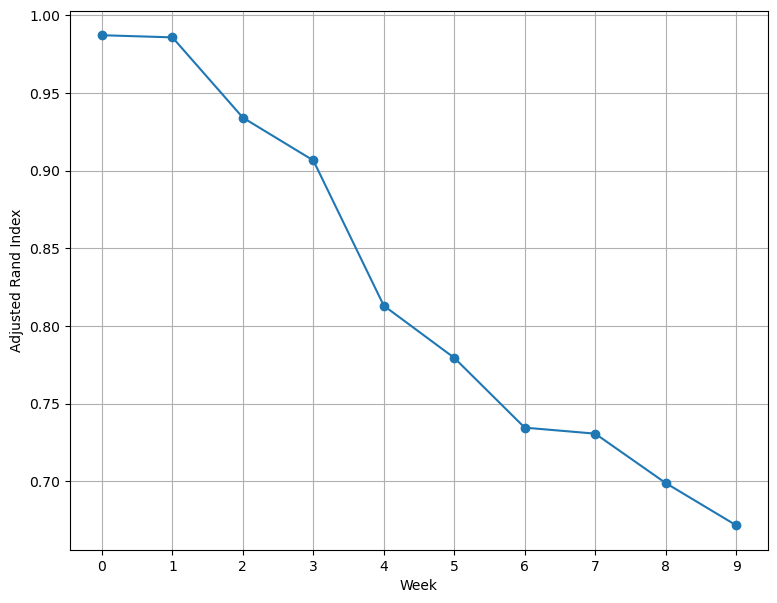

In [10]:
# Taille de la figure
plt.figure(figsize=(9, 7))

# Line plot
plt.plot(ari_df.index, ari_df, marker='o')

# Labels, grille et affichage
plt.ylabel('Adjusted Rand Index')
plt.xlabel('Week')
plt.xticks(weeks_arr)
plt.grid()
plt.show()

Nous pouvons voir qu'après chaque semaine, l'ARI diminue. Un ARI égal à 1 indique que les clusters comparés sont les mêmes. Nous allons considérer que les segments ne sont plus stables lorsque l'ARI est inférieur à 0.8 (80%). Par conséquent, le délai de maintenance sera d'un peu plus de 4 semaines, c'est-à-dire environ 1 mois.